In [48]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
import matplotlib.pyplot as plt

# Part 1: Data Augmentation

In [49]:
# Load dataset
transactions = pd.read_csv("customer_transactions.csv")

### Handle missing values

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# Predict missing numerical values
def predict_missing_values(df, target_column):
    """Fills missing values using predictive modeling."""
    known = df[df[target_column].notna()]
    unknown = df[df[target_column].isna()]

    if unknown.empty:
        return df

    X_train = known.drop(columns=[target_column])
    y_train = known[target_column]

    # Choose a predictive model (Linear Regression for continuous data)
    model = LinearRegression() if y_train.dtype.kind in 'if' else KNeighborsRegressor(n_neighbors=5)

    model.fit(X_train, y_train)
    df.loc[df[target_column].isna(), target_column] = model.predict(unknown.drop(columns=[target_column]))

    return df

# Apply predictive modeling to numerical missing values
for col in transactions.select_dtypes(include=[np.number]).columns:
    if transactions[col].isna().sum() > 0:
        transactions = predict_missing_values(transactions, col)


In [80]:
# Handle missing values
imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')
imputer_mode = SimpleImputer(strategy='most_frequent')

### Apply imputation correctly

In [85]:
# Apply imputation correctly
transactions[transactions.select_dtypes(include=[np.number]).columns] = imputer_mean.fit_transform(
    transactions.select_dtypes(include=[np.number])
)

categorical_cols = transactions.select_dtypes(exclude=[np.number]).columns
transactions[categorical_cols] = imputer_mode.fit_transform(transactions[categorical_cols])


In [56]:
print(transactions.columns)

Index(['customer_id_legacy', 'transaction_id', 'purchase_amount',
       'purchase_date', 'product_category', 'customer_rating'],
      dtype='object')


### Rename column for consistency
#### Create transaction count per customer
##### Apply random noise for synthetic data

In [76]:
def add_noise(df, col, noise_level=0.05):
    """Adds random noise to a numerical column."""
    if col in df.columns:
        noise = np.random.normal(0, noise_level * df[col].std(), df.shape[0])
        df[col] += noise
    else:
        print(f"Warning: Column '{col}' not found for noise addition.")

In [77]:
# Rename column for consistency
transactions.rename(columns={'purchase_amount': 'amount_spent'}, inplace=True)

# Create transaction count per customer
if 'transaction_count' not in transactions.columns:
    transactions['transaction_count'] = transactions.groupby('customer_id_legacy')['transaction_id'].transform('count')

# Apply random noise for synthetic data
for col in ['amount_spent', 'transaction_count']:
    if col in transactions.columns:
        add_noise(transactions, col)
    else:
        print(f"Warning: Column '{col}' not found in dataset.")

### Apply SMOTE for balancing

In [86]:
# Apply SMOTE for balancing
if 'customer_id_legacy' in transactions.columns:
    X = transactions.drop(columns=['customer_id_legacy'])
else:
    X = transactions.copy()  # Avoid dropping a missing column

y = transactions['customer_segment'] if 'customer_segment' in transactions.columns else None

if y is not None and y.nunique() > 1 and y.dtype.kind in 'iuf':  # Ensure it's categorical
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    transactions = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                              pd.DataFrame(y_resampled, columns=['customer_segment'])], axis=1)

### Apply log transformation to skewed data

In [60]:
# Apply log transformation to skewed data
pt = PowerTransformer()
transactions[['amount_spent']] = pt.fit_transform(transactions[['amount_spent']])

In [78]:
def generate_synthetic_transactions(df, num_new=500):
    """Generates new synthetic transactions based on customer behavior patterns."""
    synthetic_data = df.sample(n=num_new, replace=True).copy()

    # Apply variations
    synthetic_data['amount_spent'] *= np.random.uniform(0.8, 1.2, num_new)  # Slight variation
    synthetic_data['transaction_count'] = np.round(synthetic_data['transaction_count'] * np.random.uniform(0.9, 1.1, num_new))

    return synthetic_data

# Generate synthetic transactions and add them to the dataset
synthetic_transactions = generate_synthetic_transactions(transactions, num_new=500)
transactions = pd.concat([transactions, synthetic_transactions], ignore_index=True)


In [61]:
# Save augmented data
transactions.to_csv("customer_transactions_augmented.csv", index=False)

# Part 2: Merging Datasets with Transitive Properties

In [62]:
# Part 2: Merging Datasets with Transitive Properties
transactions_aug = pd.read_csv("customer_transactions_augmented.csv")
social_profiles = pd.read_csv("customer_social_profiles.csv")
id_mapping = pd.read_csv("id_mapping.csv")

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF transformation if text data exists
if 'social_media_comments' in social_profiles.columns:
    vectorizer = TfidfVectorizer(max_features=100)
    tfidf_matrix = vectorizer.fit_transform(social_profiles['social_media_comments'].fillna(''))

    # Convert TF-IDF result into a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Concatenate TF-IDF features with original social profile data
    social_profiles = pd.concat([social_profiles.drop(columns=['social_media_comments']), tfidf_df], axis=1)


### Merge using ID mapping

In [87]:
id_mapping = id_mapping.drop_duplicates(subset=['customer_id_legacy'], keep='first')

In [66]:
# Merge using ID mapping
merged_data = transactions_aug.merge(id_mapping, left_on='customer_id_legacy', right_on='customer_id_legacy', how='left')

# Ensure 'customer_id_new' exists before merging with social_profiles
if 'customer_id_new' in merged_data.columns and 'customer_id_new' in social_profiles.columns:
    merged_data = merged_data.merge(social_profiles, left_on='customer_id_new', right_on='customer_id_new', how='left')
else:
    raise KeyError("No matching customer ID column found for merging social profiles.")

# Drop unnecessary columns if they exist
merged_data.drop(columns=['customer_id_legacy', 'customer_id_new'], errors='ignore', inplace=True)

In [81]:
# Check for duplicate customer mappings
duplicate_mappings = id_mapping[id_mapping.duplicated(subset=['customer_id_legacy'], keep=False)]
if not duplicate_mappings.empty:
    print("Warning: Multiple customer_id_new found for same customer_id_legacy. Resolving by selecting the first occurrence.")

# Deduplicate mapping by keeping the first occurrence
id_mapping = id_mapping.drop_duplicates(subset=['customer_id_legacy'], keep='first')

# Merge after resolving conflicts
merged_data = transactions_aug.merge(id_mapping, on='customer_id_legacy', how='left')

### Feature Engineering

In [67]:
# Feature Engineering
merged_data['customer_engagement_score'] = merged_data['transaction_count'] * merged_data['purchase_interest_score']
merged_data['transaction_moving_avg'] = merged_data['amount_spent'].rolling(window=3, min_periods=1).mean()

       customer_id_legacy  transaction_id  amount_spent  customer_rating  \
count          150.000000      150.000000  1.500000e+02       150.000000   
mean           148.760000     1075.500000  3.434290e-16         2.985000   
std             30.046425       43.445368  1.003350e+00         1.165783   
min            100.000000     1001.000000 -2.154989e+00         1.000000   
25%            121.250000     1038.250000 -8.000816e-01         2.100000   
50%            150.500000     1075.500000  1.145638e-02         2.985000   
75%            174.750000     1112.750000  9.129530e-01         4.000000   
max            199.000000     1150.000000  1.689911e+00         5.000000   

       transaction_count  
count         150.000000  
mean            2.609334  
std             1.318461  
min             0.961307  
25%             1.965153  
50%             2.019954  
75%             3.033529  
max             6.033360  


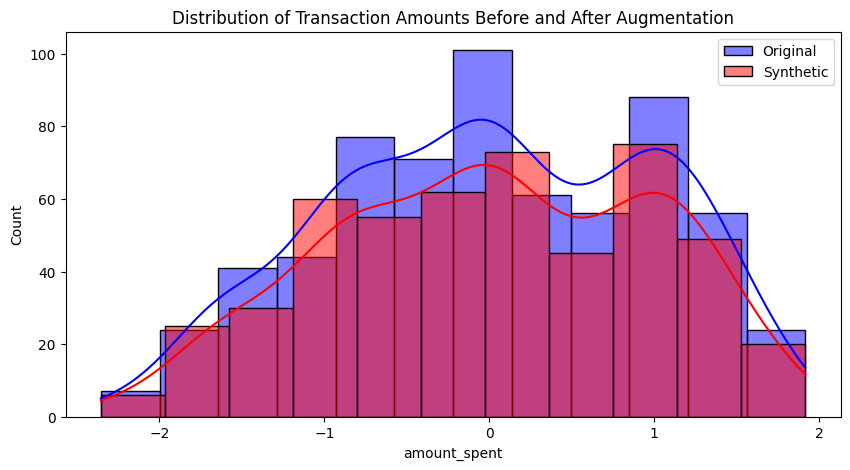

In [82]:
# Print summary statistics
print(merged_data.describe())

# Plot distribution of transaction amounts before and after augmentation
plt.figure(figsize=(10, 5))
sns.histplot(transactions['amount_spent'], kde=True, label='Original', color='blue', alpha=0.5)
sns.histplot(synthetic_transactions['amount_spent'], kde=True, label='Synthetic', color='red', alpha=0.5)
plt.legend()
plt.title("Distribution of Transaction Amounts Before and After Augmentation")
plt.show()


In [68]:
# Save merged dataset
merged_data.to_csv("final_customer_data_group1.csv", index=False)

# Part 3: Data Consistency & Quality Checks

In [69]:
# Part 3: Data Consistency & Quality Checks
# Remove duplicates
merged_data.drop_duplicates(inplace=True)

### Check correlations

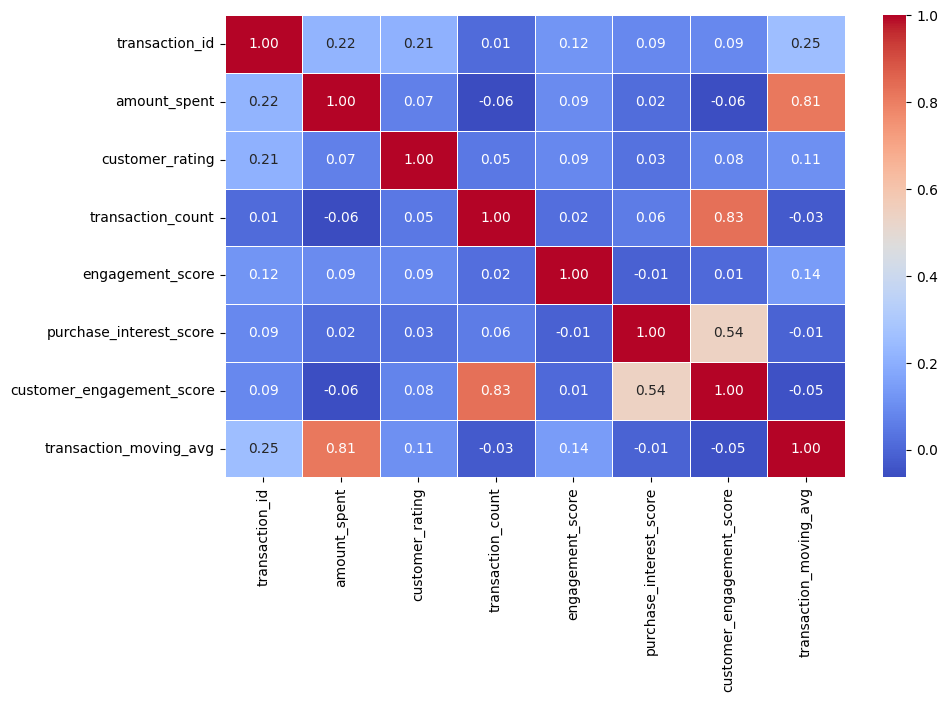

In [71]:
# Check correlations
numeric_data = merged_data.select_dtypes(include=[np.number])  # Select only numeric columns

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()


### Ensure only existing columns are dropped

In [73]:
# Ensure only existing columns are dropped
columns_to_drop = [col for col in ['customer_id', 'customer_segment'] if col in merged_data.columns]
X_final = merged_data.drop(columns=columns_to_drop)

# Ensure target variable exists
y_final = merged_data['customer_segment'] if 'customer_segment' in merged_data.columns else None

# Select best features if y_final is not None
if y_final is not None:
    selector = SelectKBest(score_func=f_classif, k=min(10, X_final.shape[1]))  # Adjust k to available features
    X_selected = selector.fit_transform(X_final, y_final)
    selected_features = X_final.columns[selector.get_support()]
    merged_data = merged_data[selected_features.tolist() + ['customer_segment']]

In [83]:
# Ensure all transactions have a valid social profile
valid_customers = social_profiles['customer_id_new'].unique()
merged_data = merged_data[merged_data['customer_id_new'].isin(valid_customers)]

# Check if any transactions are missing a match
missing_profiles = merged_data['customer_id_new'].isna().sum()
if missing_profiles > 0:
    print(f"Warning: {missing_profiles} customer transactions have no matching social profile.")

In [74]:
# Save final dataset
merged_data.to_csv("final_dataset_ready_group1.csv", index=False)